<a href="https://colab.research.google.com/github/Yason-9/nhl_data_science/blob/main/tfds_exer_flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [2]:
splits = ['train[:70%]', 'train[70%:]']
(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    as_supervised=True,
    with_info=True,
    split=splits
)



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [3]:
num_training_examples = int(dataset_info.splits['train'].num_examples * 0.7)
num_validation_examples = int(dataset_info.splits['train'].num_examples * 0.3)
num_classes = dataset_info.features['label'].num_classes
num_examples = dataset_info.splits['train'].num_examples


In [4]:
print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



In [5]:
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


In [6]:
IMAGE_RES = 224

In [7]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  #resizing syntax, divide by 255 to normalize pixel values between 0 and
  return image, label

BATCH_SIZE = 32
train_batches = training_set.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [8]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape = (IMAGE_RES, IMAGE_RES, 3))
#NEEDS TO BE A 3D ARRAY, NOT JUST (IMAGE_RES, IMAGE_RES)

In [9]:
feature_extractor.trainable = False

In [10]:
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [11]:
EPOCHS = 6

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[['accuracy']]
)

history = model.fit(
    train_batches,
    epochs=EPOCHS,
    validation_data = validation_batches
)

Epoch 1/6
81/81 [==============================] - 22s 114ms/step - loss: 0.7496 - accuracy: 0.7139 - val_loss: 0.4581 - val_accuracy: 0.8383
Epoch 2/6
81/81 [==============================] - 4s 48ms/step - loss: 0.3775 - accuracy: 0.8750 - val_loss: 0.3569 - val_accuracy: 0.8856
Epoch 3/6
81/81 [==============================] - 5s 56ms/step - loss: 0.2938 - accuracy: 0.9074 - val_loss: 0.3229 - val_accuracy: 0.8901
Epoch 4/6
81/81 [==============================] - 5s 66ms/step - loss: 0.2453 - accuracy: 0.9245 - val_loss: 0.3230 - val_accuracy: 0.8965
Epoch 5/6
81/81 [==============================] - 4s 48ms/step - loss: 0.2142 - accuracy: 0.9404 - val_loss: 0.2874 - val_accuracy: 0.9083
Epoch 6/6
81/81 [==============================] - 5s 56ms/step - loss: 0.1851 - accuracy: 0.9486 - val_loss: 0.2909 - val_accuracy: 0.9037


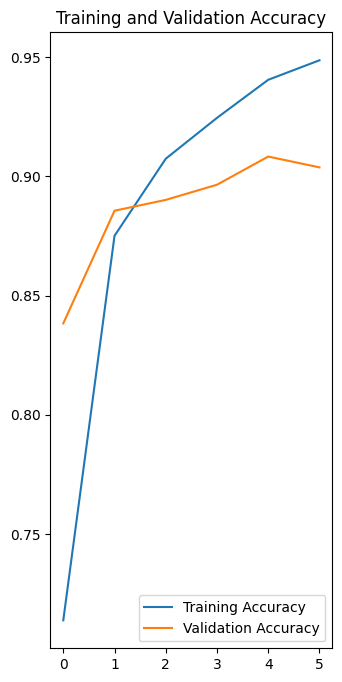

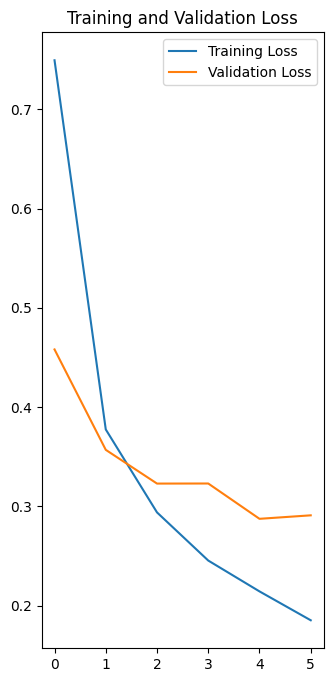

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [20]:
class_names = np.array(dataset_info.features['label'].names)

In [27]:
image_batch, label_batch = next(iter(train_batches.take(1)))
#syntax to obtain the images and their corresponding labelled values/name of flower
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
#ids corresponding to class_names which contains names of each flower
predicted_class_names = class_names[predicted_ids]

print(predicted_ids)
print(predicted_class_names)

1/1 [==============================] - 0s 92ms/step
[2 2 4 0 2 0 3 2 1 4 1 0 0 3 0 1 1 4 0 4 4 1 4 0 2 3 0 0 1 1 2 2]
['tulips' 'tulips' 'roses' 'dandelion' 'tulips' 'dandelion' 'sunflowers'
 'tulips' 'daisy' 'roses' 'daisy' 'dandelion' 'dandelion' 'sunflowers'
 'dandelion' 'daisy' 'daisy' 'roses' 'dandelion' 'roses' 'roses' 'daisy'
 'roses' 'dandelion' 'tulips' 'sunflowers' 'dandelion' 'dandelion' 'daisy'
 'daisy' 'tulips' 'tulips']


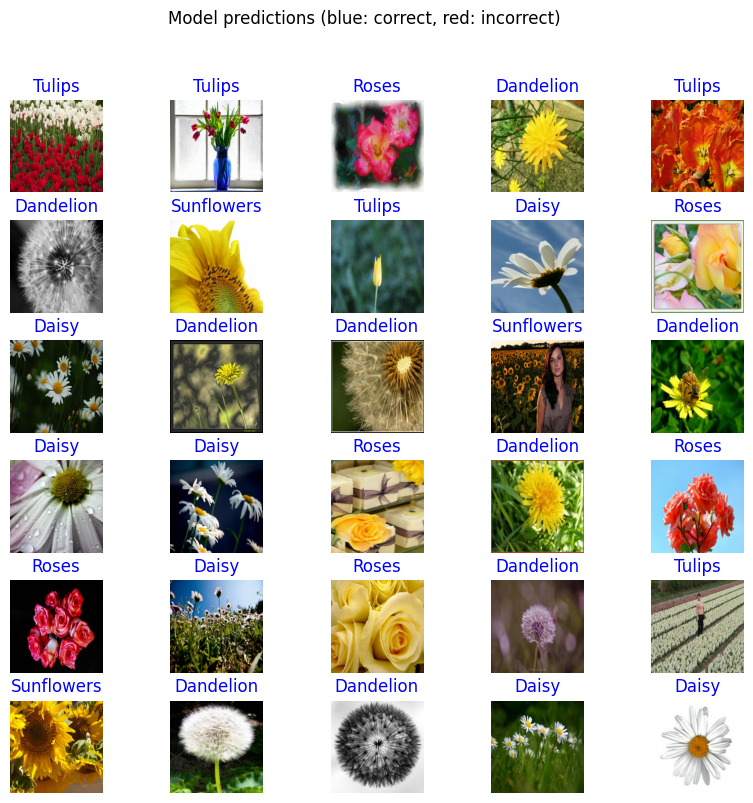

In [31]:
plt.figure(figsize=(10,9))
for n in range(30):
  #loops through the already made, predicted_ids
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  if predicted_ids[n] == label_batch[n]:
    color = "blue"
  else:
    color = "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")